In [16]:
import os
import regex as re
import pandas as pd
import matplotlib.pyplot as plt

ustawy = []
for filename in os.listdir("ustawy/"):
    with open(f"ustawy/{filename}") as f:
        text = f.read()
        ustawy.append(" ".join(text.replace("\n", " ").replace("\t", "").split()))


In [62]:
def find_year(text: str):
    year = re.findall("(?<=z dnia [0-9]+ \w+ )[0-9]+", text)
    return year[0]

In [717]:
def find_additions(text: str):
    additions = re.findall(
        r"[Dd]oda\w* (?:się|są|jest|zostają|zostają)+ (?:[Pp]kt|[Pp]kt.|[Aa]rt|[Aa]rt.|[Uu]st|[Uu]st.|§|[Dd]zia[lł])+ [0-9]+[a-z]?+",
        text,
    )
    return additions


def find_removals(text: str):
    removals = re.findall(
        r"(?:(?:[Pp]kt|[Pp]kt.|[Aa]rt|[Aa]rt.|[Uu]st|[Uu]st.|§|[Dd]zia[lł]) [0-9]+[a-z]?+)+ skre[śs]\w+ (?:się|są|jest|zostają|zostaje)*",
        text,
    )
    return removals


def find_changes(text: str):
    changes = re.findall(
        r"(?:(?:[Pp]kt|[Pp]kt.|[Aa]rt|[Aa]rt.|[Uu]st|[Uu]st.|§|[Dd]zia[lł]) [0-9]+[a-z]?+)+ otrzym\w+ brzmienie",
        text,
    )
    return changes

In [338]:
ustawy_lata = {}
for ustawa in ustawy:
    rok = find_year(ustawa)
    if rok in ustawy_lata.keys():
        ustawy_lata[rok].append(ustawa)
    else:
        ustawy_lata[rok] = [ustawa]


In [707]:
all_data = []
for rok, ustawy_list in ustawy_lata.items():
    total_ch = 0
    total_add = 0
    total_rem = 0
    for ustawa in ustawy_list:
        total_ch += len(find_changes(ustawa))
        total_add += len(find_additions(ustawa))
        total_rem += len(find_removals(ustawa))
    all_data.append([rok, total_add, total_rem, total_ch])


In [708]:
df = pd.DataFrame(all_data, columns=["year", "additions", "removals", "changes"])

In [709]:
df.head()


,year,additions,removals,changes
0,2001,1177,284,1385
1,1996,273,118,456
2,2003,294,33,641
3,1997,423,128,660
4,2000,920,327,1382


In [710]:
df["total"] = df["additions"] + df["changes"] + df["removals"]

In [711]:
df.head()


,year,additions,removals,changes,total
0,2001,1177,284,1385,2846
1,1996,273,118,456,847
2,2003,294,33,641,968
3,1997,423,128,660,1211
4,2000,920,327,1382,2629


In [712]:
df["additions%"] = df["additions"] / df["total"]
df["changes%"] = df["changes"] / df["total"]
df["removals%"] = df["removals"] / df["total"]

In [713]:
df.head()


,year,additions,removals,changes,total,additions%,changes%,removals%
0,2001,1177,284,1385,2846,0.413563,0.486648,0.099789
1,1996,273,118,456,847,0.322314,0.538371,0.139315
2,2003,294,33,641,968,0.303719,0.662190,0.034091
3,1997,423,128,660,1211,0.349298,0.545004,0.105698
4,2000,920,327,1382,2629,0.349943,0.525675,0.124382


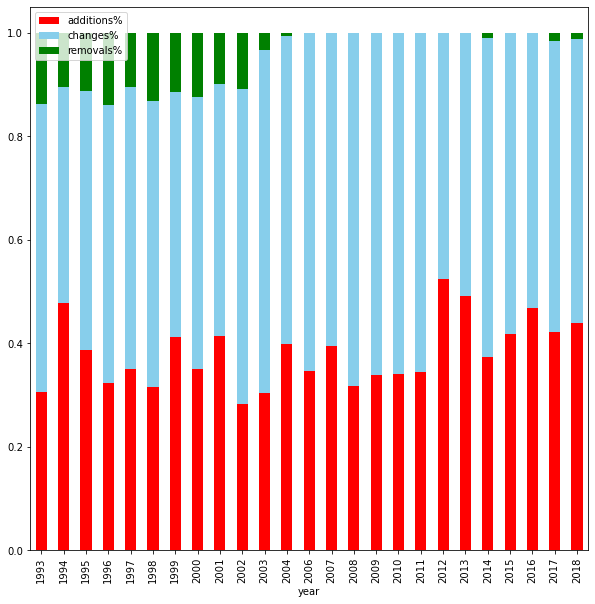

In [714]:
plt.rcParams["figure.figsize"] = (10,10)
df[["additions%", "changes%", "removals%", "year"]].set_index("year").sort_values(
    "year"
).plot(kind="bar", stacked=True, color=["red", "skyblue", "green"])
plt.show()

In [692]:
df.head()

,year,additions,removals,changes,total,additions%,changes%,removals%
0,2001,690,282,1380,2352,0.293367,0.586735,0.119898
1,1996,120,118,456,694,0.172911,0.657061,0.170029
2,2003,169,33,639,841,0.200951,0.759810,0.039239
3,1997,230,128,660,1018,0.225933,0.648330,0.125737
4,2000,502,327,1379,2208,0.227355,0.624547,0.148098


In [660]:
odmiana_list = [
    "ustawa",
    "ustawy",
    "ustawy",
    "ustaw",
    "ustawie",
    "ustawom",
    "ustawę",
    "ustawy",
    "ustawą",
    "ustawami",
    "ustawie",
    "ustawach",
    "ustawo",
    "ustawy"
]

In [661]:
odmiana_list = [rf"\b{x}\b" for x in odmiana_list]

In [662]:
odmiana_list

['\\bustawa\\b',
 '\\bustawy\\b',
 '\\bustawy\\b',
 '\\bustaw\\b',
 '\\bustawie\\b',
 '\\bustawom\\b',
 '\\bustawę\\b',
 '\\bustawy\\b',
 '\\bustawą\\b',
 '\\bustawami\\b',
 '\\bustawie\\b',
 '\\bustawach\\b',
 '\\bustawo\\b',
 '\\bustawy\\b']

In [664]:
def find_ustawa(text:str):
    ustawa = re.findall(rf"\b({'|'.join(odmiana_list)}\b)", text, re.IGNORECASE)
    return ustawa

def find_zdnia(text:str):
    find = re.findall(rf"(\b(?:{'|'.join(odmiana_list)}\b)(?= \bz dnia\b))", text, re.IGNORECASE)
    return find

def find_ustawa_not_zdnia(text:str):
    find = re.findall(rf"(\b(?:{'|'.join(odmiana_list)}\b)(?! \bz dnia\b))", text, re.IGNORECASE)
    return find 

def find_ustawa_not_o_zmianie(text:str):
    ustawa = re.findall(rf"(?! \bo zmianie\b) \b({'|'.join(odmiana_list)}\b)", text, re.IGNORECASE)
    return ustawa

In [729]:
total_ustawa_zdania = []
for rok, ustawy_list in ustawy_lata.items():
    for ustawa in ustawy_list:
        if len(find_ustawa(ustawa)) != 0:
            total_ustawa_zdania.append([len(find_ustawa(ustawa)), len(find_zdnia(ustawa)), len(find_ustawa_not_zdnia(ustawa)), len(find_ustawa_not_o_zmianie(ustawa))])


In [730]:
df_total_ustawa_zdnia = pd.DataFrame(total_ustawa_zdania, columns = ['ustawa', 'ustawa_z_dnia', 'ustawa_not_z_dnia', 'find_ustawa_not_o_zmianie'])

In [731]:
df_total_ustawa_zdnia.head()

,ustawa,ustawa_z_dnia,ustawa_not_z_dnia,find_ustawa_not_o_zmianie
0,4,2,2,4
1,33,16,17,33
2,13,3,10,13
3,9,3,6,9
4,27,5,22,27


In [675]:
print((df_total_ustawa_zdnia['ustawa'] - df_total_ustawa_zdnia['ustawa_z_dnia'] - df_total_ustawa_zdnia["ustawa_not_z_dnia"] == 0).all())

True


In [733]:
sum_df = df_total_ustawa_zdnia.sum()

In [734]:
sum_df.head()

ustawa                       24934
ustawa_z_dnia                 8587
ustawa_not_z_dnia            16347
find_ustawa_not_o_zmianie    24843
dtype: int64

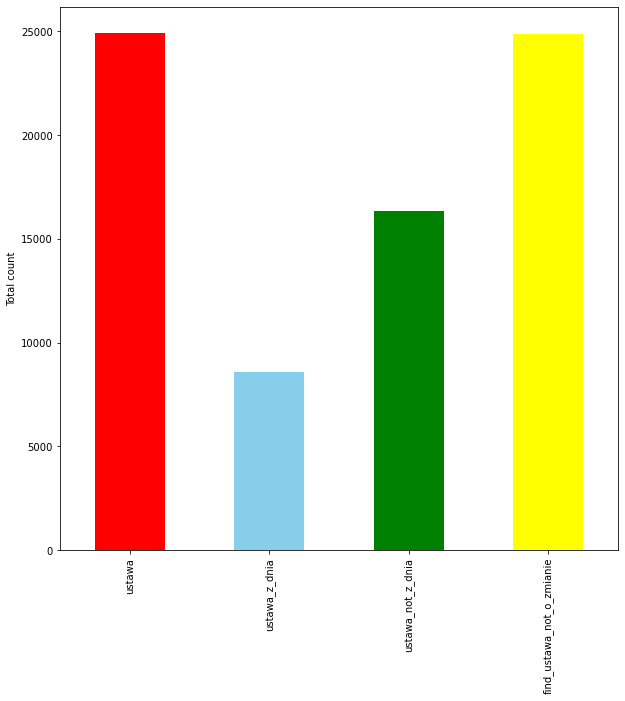

In [736]:
plt.rcParams["figure.figsize"] = (10,10)
sum_df.plot(kind="bar", color=["red", "skyblue", "green", 'yellow'])
plt.ylabel('Total count')
plt.show()